In [19]:
import polars as pl 
import polars.selectors as cs 
import seaborn as sns
import matplotlib.pyplot as plt
import get_data

In [3]:
raw_data = pl.read_csv(r"C:\Users\faune\Downloads\lab1\lab1\data\dow_jones_news.csv", separator=';').with_columns(pl.col('news').str.split('***'))

<Axes: xlabel='Date'>

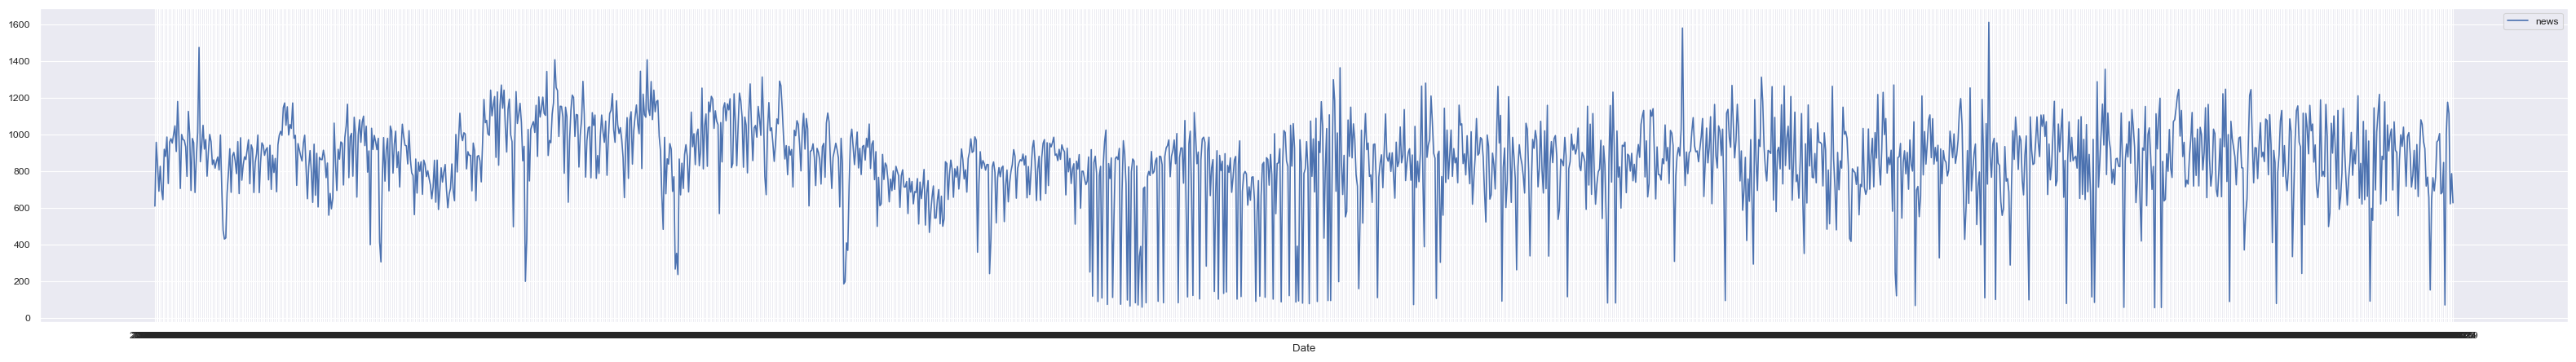

In [13]:
# sns.set_theme(context = 'paper', rc={'figure.figsize':(40,5)})
# sns.lineplot(raw_data.with_columns(pl.col('news').list.len()).drop('Label').to_pandas().set_index('Date'))

In [14]:
raw_data.with_columns(pl.col('news').list.len()).describe()

statistic,Date,Label,news
str,str,f64,f64
"""count""","""1719""",1719.0,1719.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,0.499127,850.158813
"""std""",null,0.500145,236.960182
"""min""","""2008-08-08""",0.0,55.0
"""25%""",null,0.0,748.0
"""50%""",null,0.0,877.0
"""75%""",null,1.0,994.0
"""max""","""2015-12-10""",1.0,1613.0


In [38]:
to_embed = raw_data.sort('Date').with_columns(pl.col('news').list.join('|'))

In [47]:
to_embed = (
    to_embed.with_columns(pl.col('news').str.len_chars().alias('length'))
    .with_columns(pl.when(pl.col('length').ge(8192)).then(pl.col('news').str.head(8191)).otherwise(pl.col('news')).alias('stripped_news'))
    .with_columns(pl.col('stripped_news').str.split('|').list.head(pl.col('stripped_news').str.split('|').list.len()-1).list.join('.'))
    .with_columns(pl.col('stripped_news').str.len_chars().alias('stripped_length'))
    .select('Date', 'Label', pl.col('stripped_news').alias('news'))
)

In [50]:
embeddings = get_data._get_embeddings_by_chunks(data=to_embed.select('news').to_series().to_list(), chunk_size=5)

In [55]:
with_embeddings = to_embed.with_columns(pl.Series(name = 'embeddings', values=embeddings)).rename({'Date':'date', 'Label':'label', 'news':'sentence'})

In [56]:
with_embeddings.write_parquet(r"C:\Users\faune\Desktop\thesis\daily_headlines.parquet")